In [14]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries,make_distance_graph
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pickle
transfer = ["H2@100 bar/243K (wt%)"]
interest=['CH4@100 bar/298 K (mg/g)']
new_list=[["H2@100 bar/77K (wt%)"],['H2@100 bar/243K (wt%)'],['CH4@100 bar/298 K (mg/g)']]
with open(f'{transfer[0][:2]}_{transfer[0][12:15]}_{interest[0][:2]}_{interest[0][12:15]}.pickle', 'rb') as f:
    figure_dic=pickle.load(f)

In [18]:
loud=[0,0,0,0,0,0]
#make clusters the same size with a random sample
resize=True
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],transfer[0],'topology']]=data[['MOF ID',interest[0],transfer[0],'topology']]
#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],transfer[0],'topology', 'Pc1', 'Pc2', 'Cluster']]
abridge["MOF ID"]=abridge.index

Text(0.5, 0.98, 'Prediction Analysis for H2@100 bar/243K (wt%) to CH4@100 bar/298 K (mg/g) Transfer')

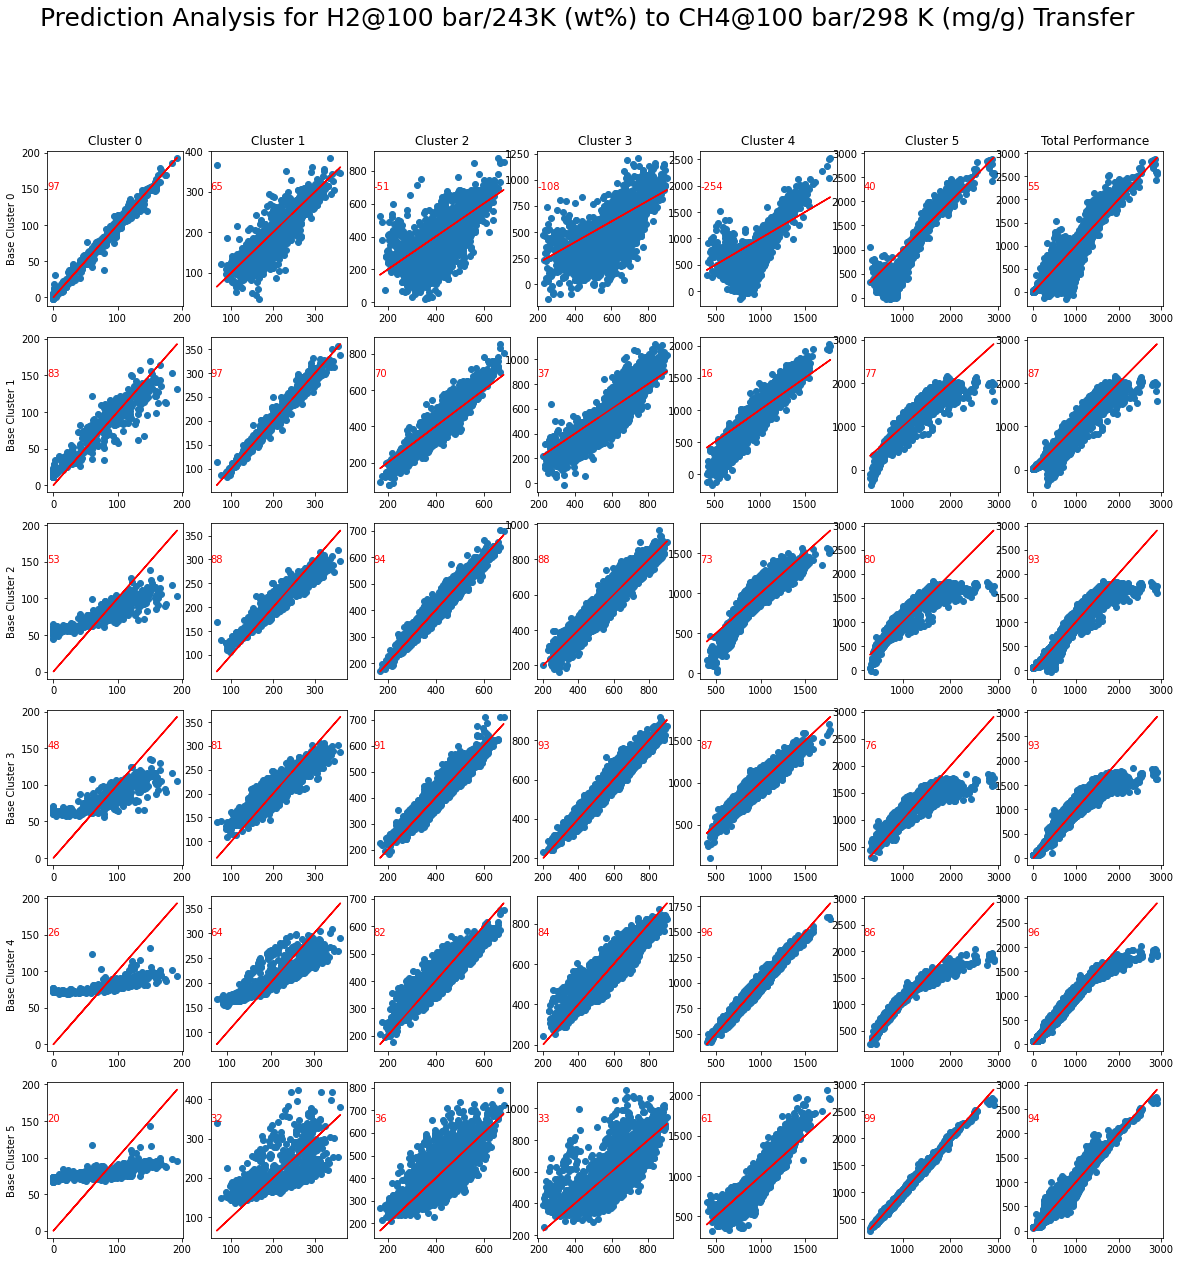

In [16]:
fig, axs = plt.subplots(6,7, figsize=(20,20))
for count,g in enumerate(figure_dic):
    temp=figure_dic[str(g)]
    slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
    slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
    temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
    slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
    for i in range(6):
        subset=slice[slice["Cluster"]==i]
        axs[count,i].scatter(subset[interest],subset["Prediction"])
        axs[count,i].plot(subset[interest].to_numpy(),subset[interest].to_numpy(),c="r")
        axs[count,i].text(0,.8,str(int(100*r2_score(subset[interest].to_numpy(),subset["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[count,i].transAxes)
    axs[count,6].text(0,.8,str(int(100*r2_score(slice[interest].to_numpy(),slice["Prediction"].to_numpy()))),c="r", ha='left', va='top', transform=axs[count,6].transAxes)
    axs[count,6].scatter(slice[interest],slice["Prediction"])
    axs[count,6].plot(slice[interest].to_numpy(),slice[interest].to_numpy(),c="r")
    axs[0,0].set_title("Cluster 0")
    axs[0,1].set_title("Cluster 1")
    axs[0,2].set_title("Cluster 2")
    axs[0,3].set_title("Cluster 3")
    axs[0,4].set_title("Cluster 4")
    axs[0,5].set_title("Cluster 5")
    axs[0,6].set_title("Total Performance")
    axs[count,0].set_ylabel(f"Base Cluster {count}")
fig.suptitle(f'Prediction Analysis for {transfer[0]} to {interest[0]} Transfer', fontsize=25)

Text(0.5, 0.98, 'Space Analysis for H2@100 bar/243K (wt%) to CH4@100 bar/298 K (mg/g) Transfer')

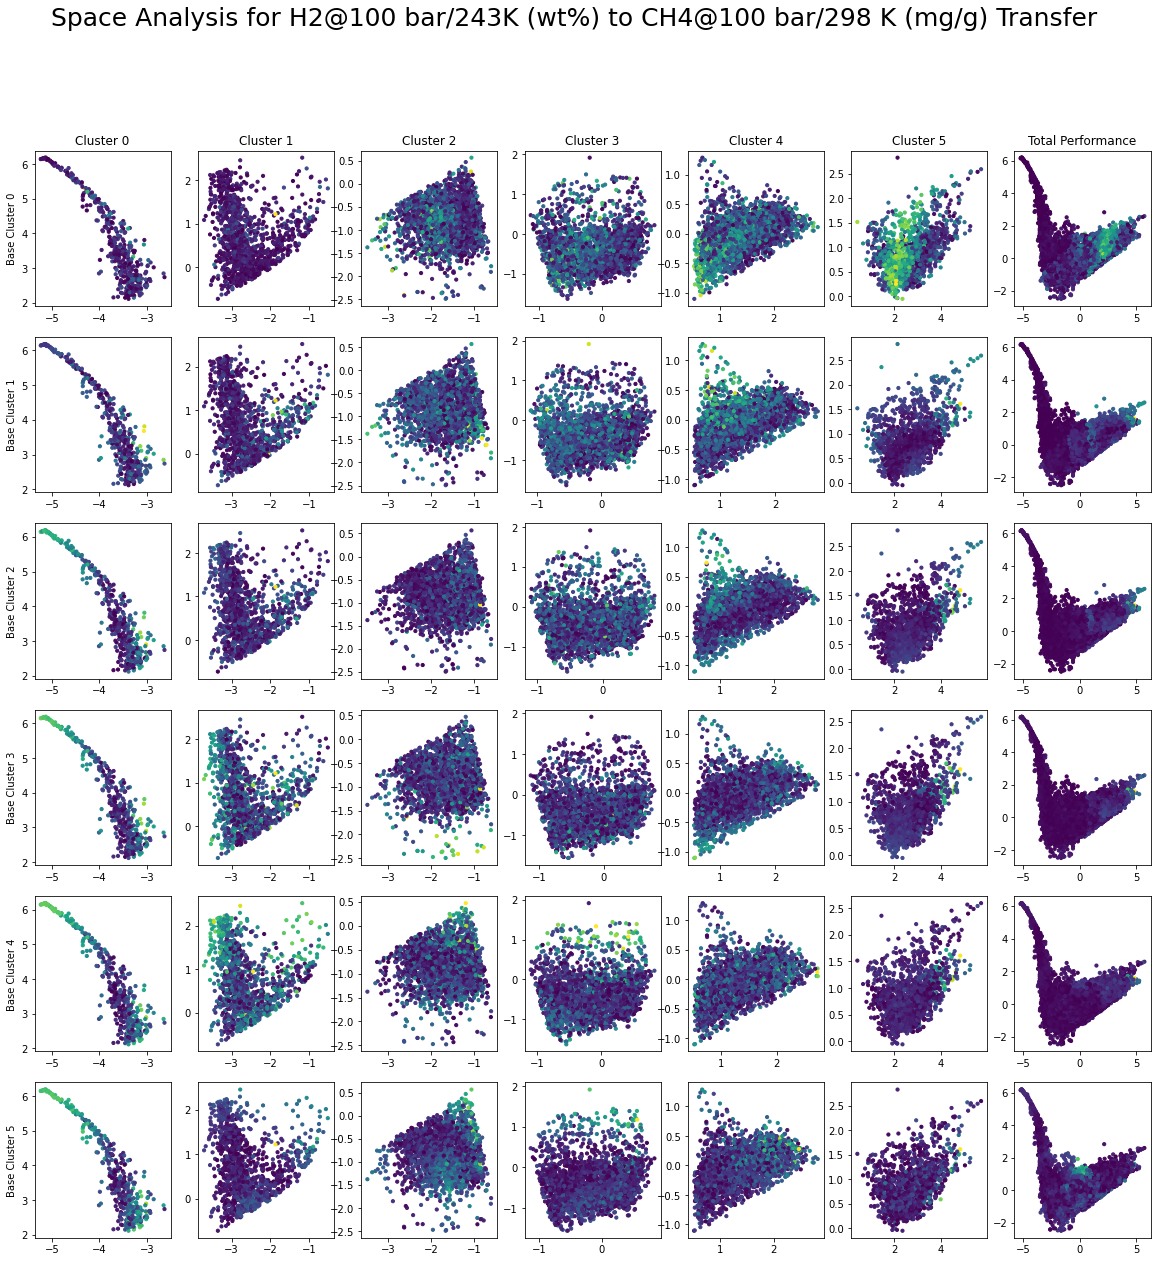

In [17]:
fig, axs = plt.subplots(6,7, figsize=(20,20))
for count,g in enumerate(figure_dic):
    temp=figure_dic[str(g)]
    slice=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])]
    slice[interest]=abridge[abridge["MOF ID"].isin(temp[temp["Count"]>=1]["MOF ID"])][interest]
    temp["Prediction"]=temp.apply(lambda x: x["Value"]/x["Count"],axis=1)
    slice=slice.join(temp,how="inner",on="MOF ID",lsuffix="2")
    slice["Error"]=slice.apply(lambda x: abs(x[interest]-x["Prediction"]),axis=1)
    for i in range(6):
        subset=slice[slice["Cluster"]==i]
        axs[count,i].scatter(subset["Pc1"],subset["Pc2"],cmap="viridis",c=subset["Error"],s=10)
    axs[count,6].scatter(slice["Pc1"],slice["Pc2"],cmap="viridis",c=slice["Error"],s=10)
    axs[0,0].set_title("Cluster 0")
    axs[0,1].set_title("Cluster 1")
    axs[0,2].set_title("Cluster 2")
    axs[0,3].set_title("Cluster 3")
    axs[0,4].set_title("Cluster 4")
    axs[0,5].set_title("Cluster 5")
    axs[0,6].set_title("Total Performance")
    axs[count,0].set_ylabel(f"Base Cluster {count}")
fig.suptitle(f'Space Analysis for {transfer[0]} to {interest[0]} Transfer', fontsize=25)

In [20]:
data.columns

Index(['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.',
       'Pore diameter Limiting', 'Pore diameter Largest',
       'H2@100 bar/77K (g/L)', 'H2@100 bar/77K (mol/kg)',
       'H2@100 bar/77K (wt%)', 'H2@100 bar/130K (g/L)',
       'H2@100 bar/130K (mol/kg)', 'H2@100 bar/130K (wt%)',
       'H2@100 bar/200K (g/L)', 'H2@100 bar/200K (mol/kg)',
       'H2@100 bar/200K (wt%)', 'H2@100 bar/243K (g/L)',
       'H2@100 bar/243K (mol/kg)', 'H2@100 bar/243K (wt%)',
       'Qst@6 bar/77K (H2)', 'Qst@6 bar/130K (H2)', 'Qst@6 bar/200K (H2)',
       'Qst@6 bar/243K (H2)', 'CH4@100 bar/298 K (v/v)',
       'CH4@100 bar/298 K (mg/g)', 'CH4@65 bar/298 K (v/v)',
       'CH4@65 bar/298 K (mg/g)', 'Qst@6 bar/298K (CH4)', '1 bar Xe mol/kg',
       '1 bar Kr mol/kg', '1 bar Selectivity', '5 bar Xe mol/kg',
       '5 bar Kr mol/kg', '5 bar Selectivity', 'topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Sec

In [22]:
data[['H2@100 bar/77K (wt%)','H2@100 bar/243K (wt%)','CH4@100 bar/298 K (mg/g)']].corr()

,H2@100 bar/77K (wt%),H2@100 bar/243K (wt%),CH4@100 bar/298 K (mg/g)
H2@100 bar/77K (wt%),1.000000,0.978722,0.988319
H2@100 bar/243K (wt%),0.978722,1.000000,0.989544
CH4@100 bar/298 K (mg/g),0.988319,0.989544,1.000000
